In [ ]:
#!pip install theano-pymc
#!pip install --upgrade pymc theano-pymc numpy pandas

In [71]:
import requests
import json
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
#import theano.tensor as tt

In [ ]:
# Set directory to Google Drive to get dataset
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/STA365')

In [63]:
# Read data
df = pd.read_csv('zone_entries_BMC_5.csv')
# Remove the 4th period - not to our interest
df = df[df["Period"] != 4]
## Find center of y-coordinate of a hockey ground
center = 0.5*sum([df['Y Coordinate'].min(), df['Y Coordinate'].max()])
center
## Convert current y-coordinate (centering)
df['Y_coordinate_centered'] = df['Y Coordinate'] - center

In [64]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
# Show first 5 columns
df.head(5)

,Date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,isin_ozone_for_home_team,isin_ozone_for_away_team,zone_entry_success,Position,is_forward,Entry_Type,Game,Dumped,Played,Carried,timeline,us_powerplay,canada_powerplay,Y_coordinate_centered,Blayre Turnbull,Emma Maltais,Savannah Harmon,Abbey Murphy,Jamie Lee Rattray,Ashton Bell,Cayla Barnes,Hilary Knight,Jessie Eldridge,Julia Gosling,Taylor Heise,Jamie Bourbonnais,Rory Guilday,Sarah Nurse,Brianne Jenner,Jessica DiGirolamo,Sarah Fillier,Ella Shelton,Rebecca Gilmore,Grace Zumwinkle,Hayley Scamurra,Renata Fast,Megan Keller,Jocelyne Larocque,Marie-Philip Poulin,Kelly Pannek,Britta Curl,Lacey Eden,Alex Carpenter,Abby Roque,Tessa Janecke,Hannah Bilka,Laura Stacey,Kristin O'Neill,Haley Winn,Gabbie Hughes,Emily Clark,Erin Ambrose,Natalie Buchbinder,Sophie Jaques,Laila Edwards,Kirsten Simms,Caroline Harvey,Anna Wilgren,Nicole Gosling,Loren Gabel,Danielle Serdachny,Jennifer Gardiner,Anne Cherkowski,Allyson Simpson,Casey O'Brien,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,2023-11-08,Women - United States,Women - Canada,1,19:36,5,5,0,0,Women - Canada,Blayre Turnbull,Zone Entry,125,6,Carried,NaN,NaN,NaN,Haley Winn,NaN,NaN,False,True,False,F,True,Carried,2023-11-08,False,False,True,24,0,0,-36.5,1.0,1.0,0.0,1,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.996268,1.087426,0.562318,1.392788,0.416130
1,2023-11-08,Women - United States,Women - Canada,1,19:23,5,5,0,0,Women - United States,Hilary Knight,Zone Entry,125,52,Dumped,NaN,NaN,NaN,Erin Ambrose,NaN,NaN,True,False,False,F,True,Dumped,2023-11-08,True,False,False,37,0,0,9.5,1.0,1.0,0.0,1,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1.0,0,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.966968,1.095312,0.722934,1.121504,0.558116
2,2023-11-08,Women - United States,Women - Canada,1,19:18,5,5,0,0,Women - Canada,Sarah Fillier,Zone Entry,125,80,Carried,NaN,NaN,NaN,Rory Guilday,NaN,NaN,False,True,False,F,True,Carried,2023-11-08,False,False,True,42,0,0,37.5,1.0,1.0,0.0,1,0.0,0.0,1.0,1,0.0,0.0,1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.267936,1.141730,1.654048,1.019390,0.618775
3,2023-11-08,Women - United States,Women - Canada,1,18:56,5,5,0,0,Women - United States,Hannah Bilka,Zone Entry,126,84,Played,NaN,NaN,NaN,Ashton Bell,NaN,NaN,True,False,False,F,True,Played,2023-11-08,False,True,False,64,0,0,41.5,0.0,0.0,0.0,0,0.0,1.0,1.0,0,0.0,0.0,0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.003440,0.715650,1.811859,0.460154,0.583678
4,2023-11-08,Women - United States,Women - Canada,1,18:48,5,5,0,0,Women - Canada,Brianne Jenner,Zone Entry,125,63,Carried,NaN,NaN,NaN,Savannah Harmon,NaN,NaN,False,True,False,F,True,Carried,2023-11-08,False,False,True,72,0,0,20.5,0.0,0.0,1.0,0,0.0,1.0,1.0,0,0.0,0.0,0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.023066,0.706057,1.832885,0.455793,0.565002


In [68]:
# Some further EDA
print(df["Game"].unique(), df["Date"].unique())
print(df["is_forward"].unique())
print(df["Player"].unique())

['2023-11-08' '2023-11-11' '2023-12-14' '2023-12-16'] ['2023-11-08' '2023-11-11' '2023-12-14' '2023-12-16']
[ True False]
['Blayre Turnbull' 'Hilary Knight' 'Sarah Fillier' 'Hannah Bilka'
 'Brianne Jenner' 'Alex Carpenter' 'Natalie Buchbinder' 'Jessie Eldridge'
 'Grace Zumwinkle' 'Jamie Lee Rattray' 'Emma Maltais' 'Cayla Barnes'
 'Ashton Bell' 'Emily Clark' 'Haley Winn' 'Abbey Murphy' 'Sarah Nurse'
 'Megan Keller' 'Lacey Eden' 'Renata Fast' 'Laura Stacey' 'Julia Gosling'
 'Jamie Bourbonnais' 'Tessa Janecke' 'Abby Roque' 'Taylor Heise'
 'Ella Shelton' 'Savannah Harmon' 'Marie-Philip Poulin' 'Hayley Scamurra'
 'Gabbie Hughes' 'Jessica DiGirolamo' "Kristin O'Neill" 'Erin Ambrose'
 'Britta Curl' 'Kelly Pannek' 'Jocelyne Larocque' 'Rory Guilday'
 'Sophie Jaques' 'Laila Edwards' 'Jennifer Gardiner' 'Caroline Harvey'
 'Loren Gabel' 'Kirsten Simms' 'Danielle Serdachny' 'Anna Wilgren'
 'Anne Cherkowski' 'Allyson Simpson']


From our EDA, here's a list of variables of interest:
- zone_entry_success - the outcome variable
- Entry_Type
- Period
- Y_coordinate_centered
- Team
- us_powerplay
- canada_powerplay
- is_forward - whether the player has an offense position
- Game (random effect)
- Player (random effect)


In [70]:
# Dummies variables for categorical variables
period_dummy = pd.get_dummies(df['Period'], prefix='Period').astype(int)
type_dummy = pd.get_dummies(df['Entry_Type'], prefix='Entry_Type').astype(int)
team_dummy = pd.get_dummies(df['Team'], prefix='Team').astype(int)
print(type_dummy)

     Entry_Type_Carried  Entry_Type_Dumped  Entry_Type_Played
0                     1                  0                  0
1                     0                  1                  0
2                     1                  0                  0
3                     0                  0                  1
4                     1                  0                  0
..                  ...                ...                ...
522                   1                  0                  0
523                   0                  1                  0
524                   0                  1                  0
525                   1                  0                  0
526                   1                  0                  0

[527 rows x 3 columns]


In [72]:
# Adding these dummy variables back to the DataFrame
df1 = pd.concat([df, period_dummy, type_dummy, team_dummy], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 526
Data columns (total 94 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        527 non-null    object 
 1   Home Team                   527 non-null    object 
 2   Away Team                   527 non-null    object 
 3   Period                      527 non-null    int64  
 4   Clock                       527 non-null    object 
 5   Home Team Skaters           527 non-null    int64  
 6   Away Team Skaters           527 non-null    int64  
 7   Home Team Goals             527 non-null    int64  
 8   Away Team Goals             527 non-null    int64  
 9   Team                        527 non-null    object 
 10  Player                      527 non-null    object 
 11  Event                       527 non-null    object 
 12  X Coordinate                527 non-null    int64  
 13  Y Coordinate                527 non

In [73]:
# Drop unnecessary columns
df1 = df1[['Period_1', 'Period_2', 'Period_3', 'Entry_Type_Carried',
           'Entry_Type_Dumped', 'Entry_Type_Played', 'Team_Women - Canada',
           'Team_Women - United States', 'Y_coordinate_centered',
           'zone_entry_success', 'us_powerplay', 'canada_powerplay']]

df1.head(5)

,Period_1,Period_2,Period_3,Entry_Type_Carried,Entry_Type_Dumped,Entry_Type_Played,Team_Women - Canada,Team_Women - United States,Y_coordinate_centered,zone_entry_success,us_powerplay,canada_powerplay
0,1,0,0,1,0,0,1,0,-36.5,False,0,0
1,1,0,0,0,1,0,0,1,9.5,False,0,0
2,1,0,0,1,0,0,1,0,37.5,False,0,0
3,1,0,0,0,0,1,0,1,41.5,False,0,0
4,1,0,0,1,0,0,1,0,20.5,False,0,0


## A simple logistic model, can be skipped

In [75]:
# Define parameters, the design matrix and the outcome
n, p = df1.shape[0], df1.shape[1] - 1
X = np.hstack((np.ones((n, 1)),
               df1[['Period_1', 'Period_2', 'Period_3', 'Entry_Type_Carried',
           'Entry_Type_Dumped', 'Entry_Type_Played', 'Team_Women - Canada',
           'Team_Women - United States', 'Y_coordinate_centered','us_powerplay', 'canada_powerplay']].values))
y = df1['zone_entry_success'].values

In [76]:
with pm.Model() as logistic_model1:
    betas = pm.Normal('betas', mu=0, sigma=50, shape=X.shape[1])
    # Linear combination of inputs and weights
    logits = pm.math.dot(X, betas)

    # Likelihood (sampling distribution) of observations
    observed = pm.Bernoulli('observed', pm.math.sigmoid(logits), observed=y)

with logistic_model1:
    logistic_model1_samples = pm.sample()

In [77]:
# Generate summary statistics after model fitting
az.summary(logistic_model1_samples, round_to=2)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],2.21,35.67,-56.89,74.72,1.56,1.11,522.26,798.10,1.00
betas[1],-1.42,25.63,-49.50,46.30,1.41,1.00,331.50,457.39,1.01
betas[2],-1.47,25.63,-47.39,48.19,1.41,1.00,331.84,457.39,1.01
betas[3],-1.59,25.62,-49.44,46.16,1.41,1.00,332.26,484.69,1.01
betas[4],0.41,26.42,-44.73,51.37,1.33,0.94,395.75,732.01,1.00
betas[5],-1.12,26.42,-46.48,49.51,1.33,0.94,395.53,709.88,1.00
betas[6],-0.33,26.41,-46.88,49.37,1.33,0.94,396.48,756.24,1.00
betas[7],-0.93,30.77,-59.53,52.55,1.52,1.07,411.36,543.44,1.00
betas[8],-1.15,30.78,-59.57,52.47,1.52,1.07,411.26,547.08,1.00
betas[9],0.00,0.00,-0.00,0.01,0.00,0.00,1709.49,1136.28,1.00


HMC Split-Rhats {'betas': array([1.0025, 1.011 , 1.0111, 1.011 , 1.0029, 1.003 , 1.003 , 1.005 ,
       1.005 , 1.0014, 0.9995, 1.0003])}


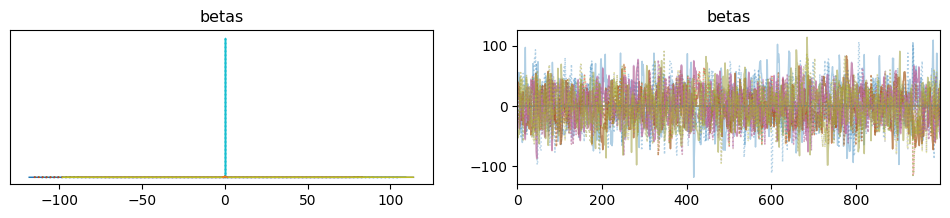

In [80]:
# Sketch the trace plot
az.plot_trace(logistic_model1_samples)
print("HMC Split-Rhats",
 {k: np.round(v.values,4) for k,v in az.rhat(logistic_model1_samples).items()})



## A Logistic model with random effects of players

In [81]:
is_forward_dummy = pd.get_dummies(df['is_forward'], prefix='Team').astype(int)
df['player_id'] = df['Player'].astype('category').cat.codes
# Adding these dummy variables back to the DataFrame
df2 = pd.concat([df, period_dummy, type_dummy, team_dummy,
                 is_forward_dummy], axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 526
Data columns (total 97 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        527 non-null    object 
 1   Home Team                   527 non-null    object 
 2   Away Team                   527 non-null    object 
 3   Period                      527 non-null    int64  
 4   Clock                       527 non-null    object 
 5   Home Team Skaters           527 non-null    int64  
 6   Away Team Skaters           527 non-null    int64  
 7   Home Team Goals             527 non-null    int64  
 8   Away Team Goals             527 non-null    int64  
 9   Team                        527 non-null    object 
 10  Player                      527 non-null    object 
 11  Event                       527 non-null    object 
 12  X Coordinate                527 non-null    int64  
 13  Y Coordinate                527 non

In [82]:
# Drop unnecessary columns
df2 = df2[['Period_1', 'Period_2', 'Period_3', 'Entry_Type_Carried',
           'Entry_Type_Dumped', 'Entry_Type_Played', 'Team_Women - Canada',
           'Team_Women - United States', 'Y_coordinate_centered', 'player_id',
           'zone_entry_success', 'us_powerplay', 'canada_powerplay']]
df2.head(5)

,Period_1,Period_2,Period_3,Entry_Type_Carried,Entry_Type_Dumped,Entry_Type_Played,Team_Women - Canada,Team_Women - United States,Y_coordinate_centered,player_id,zone_entry_success,us_powerplay,canada_powerplay
0,1,0,0,1,0,0,1,0,-36.5,7,False,0,0
1,1,0,0,0,1,0,0,1,9.5,22,False,0,0
2,1,0,0,1,0,0,1,0,37.5,42,False,0,0
3,1,0,0,0,0,1,0,1,41.5,20,False,0,0
4,1,0,0,1,0,0,1,0,20.5,8,False,0,0


In [83]:
# Define parameters, the design matrix and the outcome
n, p = df2.shape[0], df2.shape[1] - 2 # With additional random effect for players
X = np.hstack((np.ones((n, 1)),
               df2[['Period_1', 'Period_2', 'Period_3', 'Entry_Type_Carried',
           'Entry_Type_Dumped', 'Entry_Type_Played', 'Team_Women - Canada',
           'Team_Women - United States', 'Y_coordinate_centered', 'us_powerplay', 'canada_powerplay']].values))
y = df2['zone_entry_success'].values
# Map player IDs to a contiguous set of indices for indexing the random intercepts
player_ids = df2['player_id'].astype('category').cat.codes.values
num_players = len(np.unique(player_ids))

In [110]:
with pm.Model() as glmm2:
    # Fixed effects
    betas = pm.Normal('betas', mu=0, sigma=10, shape=X.shape[1])

    # Random intercepts for players
    sigma_player = pm.HalfNormal('sigma_player', sigma=1)
    intercepts_player = pm.Normal('intercepts_player', mu=0, sigma=sigma_player,
                                  shape=num_players)

    # Linear combination of inputs and weights, including random intercepts for players
    logits = pm.math.dot(X, betas) + intercepts_player[player_ids]
    p_success = pm.Deterministic('p_success', pm.math.sigmoid(logits))

    # Likelihood (sampling distribution) of observations
    observed = pm.Bernoulli('observed', p=p_success, observed=y)

with glmm2:
    glmm2_samples = pm.sample()

In [100]:
with pm.Model() as glmm1:
    # Fixed effects
    betas = pm.Normal('betas', mu=0, sigma=50, shape=X.shape[1]) #replace mu with an np.array, and sigma too

    # Random intercepts for players
    sigma_player = pm.HalfNormal('sigma_player', sigma=50)
    intercepts_player = pm.Normal('intercepts_player', mu=0, sigma=sigma_player,
                                  shape=num_players)

    # Linear combination of inputs and weights, including random intercepts for players
    logits = pm.math.dot(X, betas) + intercepts_player[player_ids]

    # Likelihood (sampling distribution) of observations
    observed = pm.Bernoulli('observed', pm.math.sigmoid(logits), observed=y)

with glmm1:
    glmm1_samples = pm.sample()
# This warning: pyMC decides the computation reached an end
# target_accept is tuned automatically, but could be manually tuned (not point of project)


In [111]:
# Generate summary statistics after model fitting
az.summary(glmm1_samples, var_names=['betas'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.05,36.45,-66.59,68.66,1.63,1.16,499.17,556.76,1.00
betas[1],0.24,26.52,-48.24,53.77,1.45,1.03,332.56,448.55,1.01
betas[2],0.20,26.52,-49.39,52.62,1.46,1.03,331.79,440.64,1.01
betas[3],0.07,26.52,-49.06,53.08,1.46,1.03,331.79,440.64,1.01
betas[4],0.25,26.27,-46.56,52.88,1.71,1.21,240.03,328.37,1.01
betas[5],-1.29,26.27,-47.76,51.62,1.71,1.21,239.91,328.37,1.01
betas[6],-0.44,26.27,-47.62,51.79,1.71,1.21,240.09,338.06,1.01
betas[7],-0.27,30.80,-57.92,55.53,1.39,0.98,490.33,795.89,1.00
betas[8],-0.53,30.81,-60.44,53.01,1.39,0.99,490.04,812.53,1.00
betas[9],0.00,0.00,-0.00,0.01,0.00,0.00,1277.41,1352.46,1.00


In [112]:
# Generate summary statistics after model fitting
az.summary(glmm1_samples, var_names=['intercepts_player'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercepts_player[0],-0.03,0.31,-0.59,0.63,0.01,0.01,1001.57,813.42,1.01
intercepts_player[1],0.26,0.34,-0.35,0.88,0.02,0.01,354.64,566.57,1.01
intercepts_player[2],0.01,0.29,-0.53,0.59,0.01,0.01,1122.85,951.67,1.01
intercepts_player[3],0.05,0.40,-0.69,0.85,0.02,0.02,688.39,553.12,1.02
intercepts_player[4],0.12,0.40,-0.68,0.89,0.02,0.02,561.60,545.82,1.01
intercepts_player[5],0.11,0.39,-0.68,0.80,0.01,0.02,836.82,682.02,1.02
intercepts_player[6],0.06,0.35,-0.57,0.74,0.01,0.01,576.30,747.57,1.01
intercepts_player[7],-0.15,0.31,-0.74,0.43,0.01,0.01,691.00,593.03,1.01
intercepts_player[8],0.03,0.29,-0.61,0.55,0.01,0.01,1007.46,1088.91,1.01
intercepts_player[9],-0.08,0.33,-0.74,0.51,0.01,0.01,915.59,513.34,1.01


In [103]:
with glmm1:
    pm.compute_log_likelihood(glmm1_samples)

In [113]:
with glmm2:
    pm.compute_log_likelihood(glmm2_samples)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'intercepts_player'}>,
        <Axes: title={'center': 'intercepts_player'}>],
       [<Axes: title={'center': 'sigma_player'}>,
        <Axes: title={'center': 'sigma_player'}>]], dtype=object)

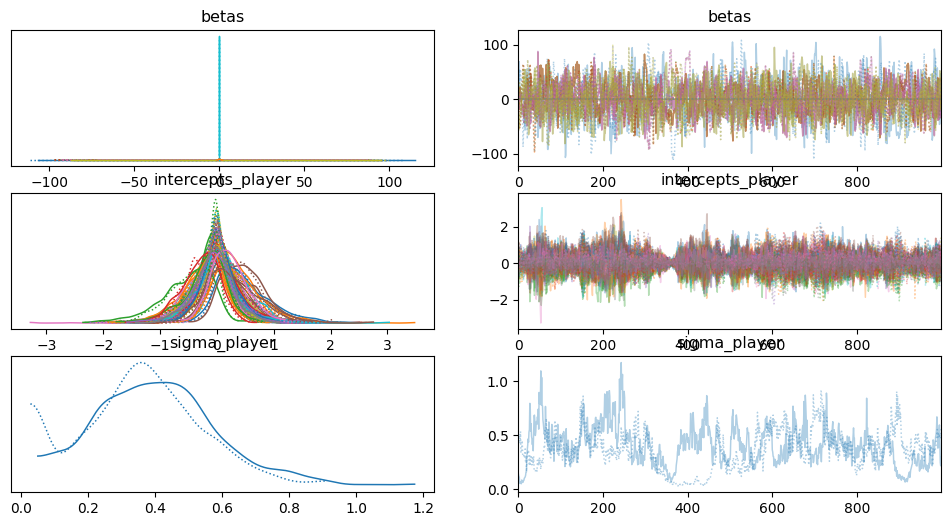

In [105]:
az.plot_trace(glmm1_samples)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'intercepts_player'}>,
        <Axes: title={'center': 'intercepts_player'}>],
       [<Axes: title={'center': 'sigma_player'}>,
        <Axes: title={'center': 'sigma_player'}>],
       [<Axes: title={'center': 'p_success'}>,
        <Axes: title={'center': 'p_success'}>]], dtype=object)

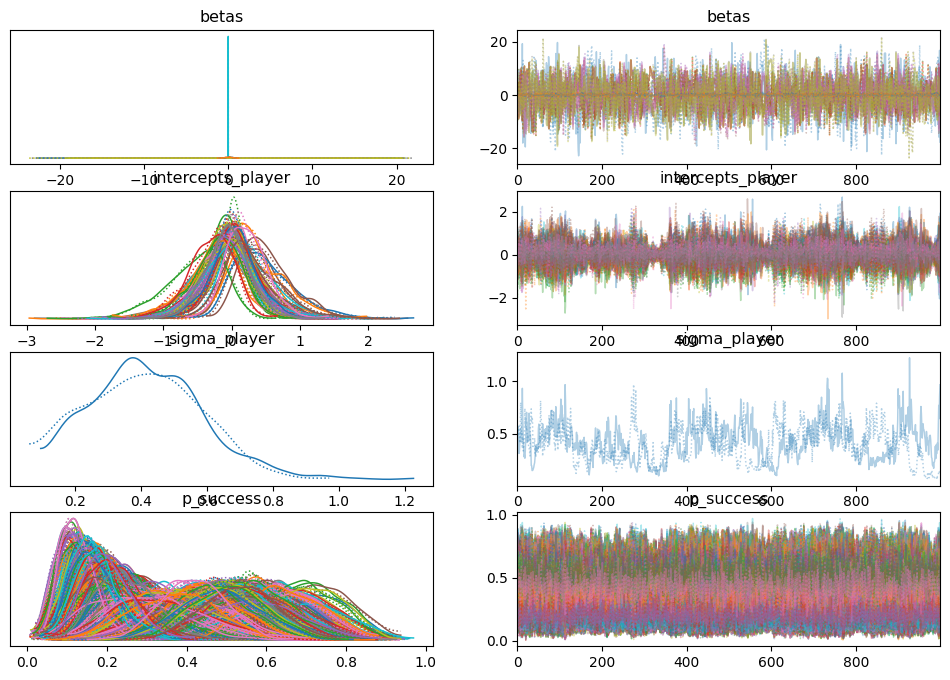

In [114]:
az.plot_trace(glmm2_samples)

Future steps:
- The summary table from the model is not informative. Need a dictionary to map each beta to its actual variable name.
- The trace plot of betas look bad. Need a way to fix it. The prof suggests this might be due to multi-collinearity. Will investigate in a frequentist setting.
- Make better prior selections (need Matthew's knowledge on hockey, and possibly conduct prior predictive checks)
- Conduct model selection steps (LOO-CV)

## Model Diagnostics & Comparisons

In [115]:
loo_result_glmm1 = az.loo(glmm1_samples, pointwise=True)
loo_result_glmm2 = az.loo(glmm2_samples, pointwise=True)

az.compare({"glmm1": glmm1_samples, "glmm2": glmm2_samples}, ic='loo')

<ipython-input-115-d1f010102a20>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo_result_glmm1 = az.loo(glmm1_samples, pointwise=True)
<ipython-input-115-d1f010102a20>:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo_result_glmm2 = az.loo(glmm2_samples, pointwise=True)


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
glmm2,0,-328.883316,21.473400,0.000000,1.000000e+00,9.313091,0.000000,False,log
glmm1,1,-329.127932,20.843054,0.244615,1.110223e-16,9.292062,0.247905,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

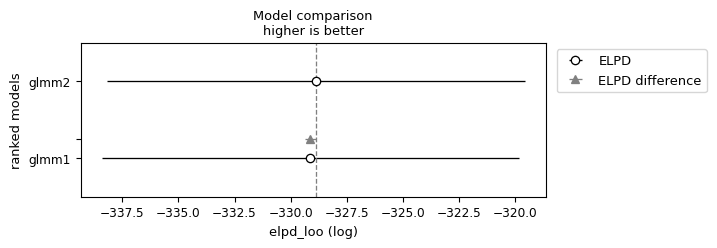

In [116]:
az.plot_compare(az.compare({"glmm1": glmm1_samples, "glmm2": glmm2_samples}), insample_dev=False)